In [1]:
import gym
import numpy as np
import random
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
env = gym.make('FrozenLake-v1')

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [3]:
# Initialize Q-value table randomly
q_table = np.zeros((env.observation_space.n, env.action_space.n))
print(q_table)

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


In [4]:
# Hyperparameters
gamma = 0.99
learning_rate = 0.1
max_epsilon = 1.0
min_epsilon = 0.01
epsilon_decay_rate = 0.005

num_episodes = 20000
num_steps_per_episode = 100

In [5]:
def q_learning(env, num_episodes, num_steps_per_episode, learning_rate, gamma, max_epsilon, min_epsilon, epsilon_decay_rate):
    q_table = np.zeros((env.observation_space.n, env.action_space.n))
    rewards_all = []
    for episode in range(num_episodes):
        state = env.reset()

        reward_episode = 0.0
        done = False
        epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-epsilon_decay_rate*episode)
        for step in range(num_steps_per_episode):
            exploration = random.uniform(0,1)
            if exploration < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(q_table[state, :])

            next_state, reward, done, info = env.step(action)
            q_table[state, action] = q_table[state, action] * (1 - learning_rate) + learning_rate * (reward + gamma * np.max(q_table[next_state,:]))

            reward_episode += reward
            state = next_state

            if done:
                break
        rewards_all.append(reward_episode)
    print(f'Episode {episode} finished')
    return q_table, rewards_all

In [6]:
q_table, rewards_all = q_learning(env, num_episodes, num_steps_per_episode, learning_rate, gamma, max_epsilon, min_epsilon, epsilon_decay_rate)

Episode 19999 finished


In [7]:
q_table

array([[0.51834968, 0.48723367, 0.47679099, 0.47642638],
       [0.26879413, 0.09740542, 0.17642537, 0.39589999],
       [0.20913863, 0.35799858, 0.19284849, 0.25445832],
       [0.11134375, 0.1146548 , 0.15400915, 0.3363539 ],
       [0.5386945 , 0.39945314, 0.38100967, 0.42905307],
       [0.        , 0.        , 0.        , 0.        ],
       [0.33777688, 0.06337134, 0.17931682, 0.04318789],
       [0.        , 0.        , 0.        , 0.        ],
       [0.35961765, 0.40723784, 0.31635745, 0.58288098],
       [0.35956662, 0.65955122, 0.39813656, 0.41747803],
       [0.66232227, 0.34072349, 0.31294069, 0.32629993],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.39331256, 0.59593935, 0.73293112, 0.51263193],
       [0.76781622, 0.84740547, 0.73337152, 0.76724932],
       [0.        , 0.        , 0.        , 0.        ]])

In [8]:
def play(env, q_table, render=False):
    state = env.reset()
    total_reward = 0
    steps = 0
    done = False
    while not done:
        action = np.argmax(q_table[state, :])
        next_state, reward, done, info = env.step(action)
        total_reward += reward
        steps += 1
        if render:
            env.render()
            time.sleep(0.2)
            if not done:
                display.clear_output(wait=True)
        state = next_state

    return (total_reward, steps)

In [9]:
def play_multiple_times(env, q_table, max_episodes):
    success = 0
    list_of_steps = []
    for i in range(max_episodes):
        total_reward, steps = play(env, q_table)

        if total_reward > 0:
            success += 1
            list_of_steps.append(steps)

    print(f'Number of successes: {success}/{max_episodes}')
    print(f'Average number of steps: {np.mean(list_of_steps)}')

In [10]:
play_multiple_times(env, q_table, 1000)

Number of successes: 740/1000
Average number of steps: 38.59324324324324


## Define SARSA

In [11]:
def sarsa_learning(env, num_episodes, num_steps_per_episode, learning_rate, gamma, max_epsilon, min_epsilon, epsilon_decay_rate):
    q_table = np.zeros((env.observation_space.n, env.action_space.n))
    rewards_all = []
    for episode in range(num_episodes):
        state = env.reset()

        reward_episode = 0.0
        done = False
        epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-epsilon_decay_rate*episode)
        # Choose A from S using policy derived from Q
        exploration = random.uniform(0,1)
        if exploration < epsilon:
            action = env.action_space.sample()
        else:
            action = np.argmax(q_table[state, :])
        for step in range(num_steps_per_episode):
            # Take action A,observe an experience (𝑠,𝑎,𝑟,𝑠′)
            next_state, reward, done, info = env.step(action)

            # Choose next action A' from S' using policy derived from Q
            exploration = random.uniform(0,1)
            if exploration < epsilon:
                next_action = env.action_space.sample()
            else:
                next_action = np.argmax(q_table[next_state, :])

            # 𝑄(𝑠,𝑎) = 𝑄(𝑠,𝑎) + 𝛼[𝑟 + 𝛾𝑄(𝑠^′,𝑎^′) − 𝑄(𝑠,𝑎)]
            q_table[state, action] = q_table[state, action] * (1 - learning_rate) + learning_rate*(reward + gamma * q_table[next_state,next_action])

            reward_episode += reward
            state = next_state
            action = next_action

            if done:
                break
        rewards_all.append(reward_episode)
    print(f'Episode {episode} finished')
    return q_table, rewards_all

## ⏳Performance of Q-Learning and SARSA


### FrozenLake-v0

In [13]:
# Hyperparameters for FrozenLake-v0
gamma = 0.99
learning_rate = 0.1
max_epsilon = 1.0
min_epsilon = 0.01
epsilon_decay_rate = 0.005
num_episodes = 20000
num_steps_per_episode = 100
env = gym.make('FrozenLake-v1')
time1= time.time()
q_table_FLv0_QL, rewards_all1 = q_learning(env, num_episodes, num_steps_per_episode, learning_rate, gamma, max_epsilon, min_epsilon, epsilon_decay_rate)
time2= time.time()
q_table_flv0_sarsa, rewards_all2 = sarsa_learning(env, num_episodes, num_steps_per_episode, learning_rate, gamma, max_epsilon, min_epsilon, epsilon_decay_rate)
time3= time.time()

Episode 19999 finished
Episode 19999 finished


In [14]:
play_multiple_times(env, q_table_FLv0_QL, 1000)
play_multiple_times(env, q_table_flv0_sarsa, 1000)
print("Time Q_Learning for FrozenLake-v1    :{:.3f}".format(time2-time1))
print("Time SARSA  for FrozenLake-v1:{:.3f}".format(time3-time2))

Number of successes: 753/1000
Average number of steps: 36.87118193891102
Number of successes: 716/1000
Average number of steps: 38.252793296089386
Time Q_Learning for FrozenLake-v1    :39.630
Time SARSA  for FrozenLake-v1:30.001


Text(0.5, 1.0, 'H1 - FrozenLake-v1')

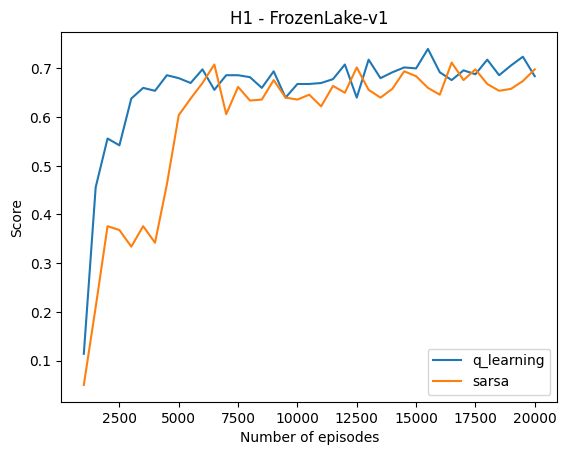

In [15]:
score_history1 =[]
score_history2 =[]
# Plotting score over time
for i in range(500,20000,500):
  score_history1.append((np.sum(rewards_all1[i-500:i])/500))
  score_history2.append((np.sum(rewards_all2[i-500:i])/500))
# plt.plot(list(range(0, 20000)), rewards_all6)
plt.plot(list(range(500, 20000+1, 500))[1:], score_history1,label='q_learning')
plt.plot(list(range(500, 20000+1, 500))[1:], score_history2,label='sarsa')
# plt.axis([0,2000,-400, 100])
plt.legend(loc='best')
plt.ylabel('Score')
plt.xlabel('Number of episodes')
plt.title("H1 - FrozenLake-v1")

### Comments
Regarding the performance of Q-Learning and SARSA on FrozenLake-v1:

1. It can be observed that SARSA is slightly faster in terms of convergence time.

2. Q-Learning outperforms SARSA significantly in the early episodes (below 10,000), while SARSA catches up with Q-Learning as the number of episodes increases beyond 10,000.

▶ Q-Learning performs better when the number of episodes is small, while SARSA shows improvement as the number of episodes increases.

### FrozenLake8x8-v1

In [17]:
# Hyperparameters for FrozenLake8x8-v1
gamma = 0.9
learning_rate = 0.8
max_epsilon = 1.0
min_epsilon = 0.001
epsilon_decay_rate = 0.00005
num_episodes = 250000
num_steps_per_episode = 400

env = gym.make('FrozenLake8x8-v1')
time4= time.time()
q_table_FL8x8v0_QL, rewards_all3 = q_learning(env, num_episodes, num_steps_per_episode, learning_rate, gamma, max_epsilon, min_epsilon, epsilon_decay_rate)
time4_2= time.time()


Episode 249999 finished


In [18]:
env = gym.make('FrozenLake8x8-v1')
time5= time.time()
q_table_fl8x8v0_sarsa, rewards_all4 = sarsa_learning(env, num_episodes, num_steps_per_episode, learning_rate, gamma, max_epsilon, min_epsilon, epsilon_decay_rate)
time6= time.time()

Episode 249999 finished


In [19]:
play_multiple_times(env, q_table_FL8x8v0_QL, 1000)
play_multiple_times(env, q_table_fl8x8v0_sarsa, 1000)
print("Time q learning for FrozenLake8x8-v1    :{:.3f}".format(time4_2-time4))
print("Time sarsa learning for FrozenLake8x8-v1:{:.3f}".format(time6-time5))

Number of successes: 677/1000
Average number of steps: 80.4903988183161
Number of successes: 535/1000
Average number of steps: 93.03364485981308
Time q learning for FrozenLake8x8-v1    :702.053
Time sarsa learning for FrozenLake8x8-v1:485.064


Text(0.5, 1.0, 'H2-FrozenLake8x8-v1')

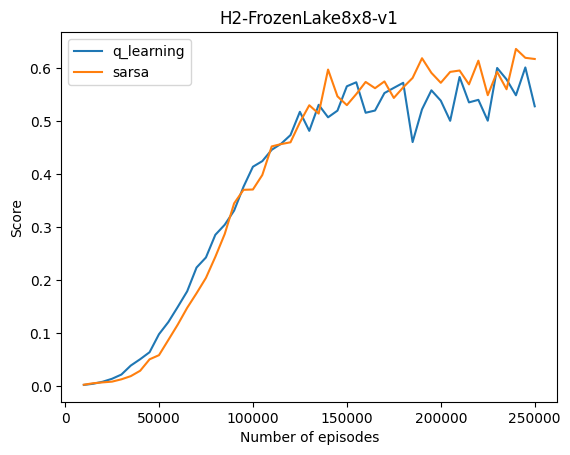

In [20]:
score_history1 =[]
score_history2 =[]
# Plotting score over time
for i in range(5000,250000,5000):
  score_history1.append((np.sum(rewards_all3[i-5000:i])/5000))
  score_history2.append((np.sum(rewards_all4[i-5000:i])/5000))
# plt.plot(list(range(0, 10000)), rewards_all6)
plt.plot(list(range(5000, 250000+1,5000))[1:], score_history1,label='q_learning')
plt.plot(list(range(5000, 250000+1,5000))[1:], score_history2,label='sarsa')
# plt.axis([0,25000,-400, 150])
plt.legend(loc='best')
plt.ylabel('Score')
plt.xlabel('Number of episodes')
plt.title("H2-FrozenLake8x8-v1")

### Comments
Regarding the performance of Q-Learning and SARSA on FrozenLake8x8-v1:

1. It can be observed that SARSA is slightly faster in terms of convergence time.

2. Q-Learning outperforms SARSA in the early episodes (below 11,000), while SARSA surpasses Q-Learning as the number of episodes increases beyond 12,000.

▶ Q-Learning performs better when the number of episodes is smaller (in the early stages), while SARSA shows improvement as the number of episodes increases.

### 🚗Taxi-v3

In [21]:
gamma = 0.99
learning_rate = 0.1
max_epsilon = 1.0
min_epsilon = 0.01
epsilon_decay_rate = 0.005
num_episodes = 10000
num_steps_per_episode = 100
env = gym.make('Taxi-v3')
time7= time.time()
q_table_taxi_QL, rewards_all5 = q_learning(env, num_episodes, num_steps_per_episode, learning_rate, gamma, max_epsilon, min_epsilon, epsilon_decay_rate)
time8= time.time()
q_table_taxi_sarsa, rewards_all6 = sarsa_learning(env, num_episodes, num_steps_per_episode, learning_rate, gamma, max_epsilon, min_epsilon, epsilon_decay_rate)
time9= time.time()

Episode 9999 finished
Episode 9999 finished


In [22]:
play_multiple_times(env, q_table_taxi_QL, 1000)
play_multiple_times(env, q_table_taxi_sarsa, 1000)
print("Time q learning for taxi-v3    :{:.3f}".format(time8-time7))
print("Time sarsa learning for taxi-v3:{:.3f}".format(time9-time8))

Number of successes: 1000/1000
Average number of steps: 13.15
Number of successes: 1000/1000
Average number of steps: 13.006
Time q learning for taxi-v3    :10.147
Time sarsa learning for taxi-v3:8.132


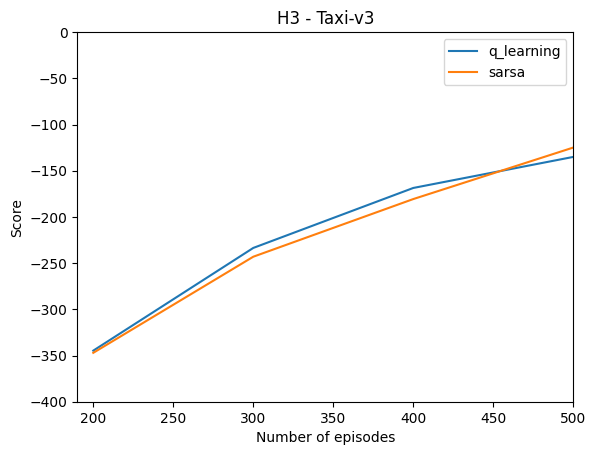

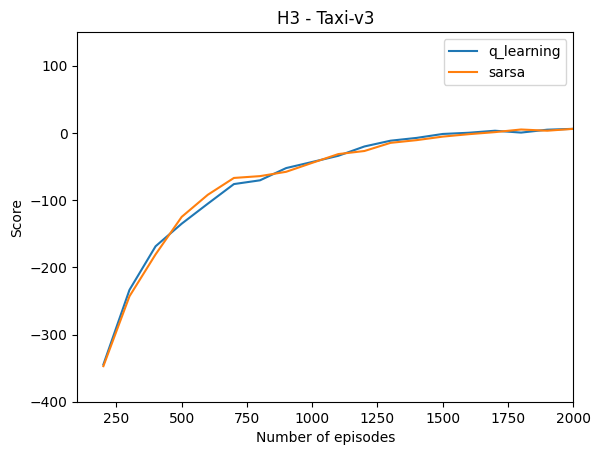

In [23]:
score_history1 =[]
score_history2 =[]
# Plotting score over time
for i in range(100,10000,100):
  score_history1.append((np.sum(rewards_all5[i-100:i])/100))
  score_history2.append((np.sum(rewards_all6[i-100:i])/100))
# plt.plot(list(range(0, 10000)), rewards_all6)
plt.plot(list(range(100, 10000+1, 100))[1:], score_history1,label='q_learning')
plt.plot(list(range(100, 10000+1, 100))[1:], score_history2,label='sarsa')
plt.axis([190,500,-400, 0])
plt.ylabel('Score')
plt.xlabel('Number of episodes')
plt.legend(loc='best')
plt.title("H3 - Taxi-v3")
plt.show()
plt.plot(list(range(100, 10000+1, 100))[1:], score_history1,label='q_learning')
plt.plot(list(range(100, 10000+1, 100))[1:], score_history2,label='sarsa')
plt.axis([100,2000,-400, 150])
plt.ylabel('Score')
plt.xlabel('Number of episodes')
plt.legend(loc='best')
plt.title("H3 - Taxi-v3")
plt.show()

Comments
Regarding the performance of Q-Learning and SARSA on Taxi-v3:

1. It can be observed that SARSA is slightly faster in terms of convergence time.

2. Q-Learning outperforms SARSA in the early episodes (below 450), while SARSA surpasses Q-Learning as the number of episodes increases beyond 300.

▶ Q-Learning performs better when the number of episodes is smaller, while SARSA shows improvement as the number of episodes increases.